In [49]:
# Define IAM role
import boto3
import re

import os
import numpy as np
import pandas as pd
from sagemaker import get_execution_role

role = get_execution_role()

In [50]:
import sagemaker
from time import gmtime, strftime

sess = sagemaker.Session() # can use LocalSession() to run container locally

bucket = sess.default_bucket()
region = "us-east-2"
account = sess.boto_session.client('sts').get_caller_identity()['Account']
prefix_input = 'detectron2-input'
prefix_output = 'detectron2-ouput'

# Upload data for training

In [ ]:
! ./upload_coco2017_to_s3.sh <your_bucket> <your_s3_path>

## Push Docker image to registry

For this training, we'll extend [Sagemaker PyTorch Container](https://docs.aws.amazon.com/deep-learning-containers/latest/devguide/deep-learning-containers-images.html) with Detectron2 dependencies (using official [D2 Dockerfile](https://github.com/facebookresearch/detectron2/blob/master/docker/Dockerfile)) as baseline. See Dockerfile below.

In [4]:
!pygmentize Dockerfile

# Build an image of Detectron2 that can do 
# distributing training and inference in Amazon Sagemaker

# using Sagemaker PyTorch container as base image
FROM 763104351884.dkr.ecr.us-east-2.amazonaws.com/pytorch-training:1.4.0-gpu-py36-cu101-ubuntu16.04
LABEL author="vadimd@amazon.com"

############# Installing latest builds ############

# This is to fix issue: https://github.com/pytorch/vision/issues/1489
RUN pip install --upgrade --force-reinstall torch torchvision cython

############# D2 section ##############

# installing dependecies for D2 https://github.com/facebookresearch/detectron2/blob/master/docker/Dockerfile
RUN pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
RUN pip install 'git+https://github.com/facebookresearch/fvcore'

ENV FORCE_CUDA="1"
# Build D2 only for Volta architecture - V100 chips (ml.p3 AWS instances)
ENV TORCH_CUDA_ARCH_LIST="Volta" 

# Build D2 from latest sources
RUN pip install 'git+https://github.com/facebookresearch/

You'll need to build container from this Dockerfile and push it to Amazon Elastic Container Registry using `build_and_push.sh` script. But you'll need to loging to Sagemaker ECR and your private ECR first.

In [37]:
# loging to Sagemaker ECR with Deep Learning Containers
!aws ecr get-login-password --region us-east-2 | docker login --username AWS --password-stdin 763104351884.dkr.ecr.us-east-2.amazonaws.com
# loging to your private ECR
!aws ecr get-login-password --region us-east-2 | docker login --username AWS --password-stdin 553020858742.dkr.ecr.us-east-2.amazonaws.com

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded


Now you can ready to push your D2 container to private ECR

In [ ]:
! ./build_and_push.sh d2-sm-coco

# Train your model

Define algorithm metrics which Sagemaker will scrap, persist, and render in training job console

In [51]:
container = "d2-sm-coco" # your container name
tag = "debug"
image = '{}.dkr.ecr.{}.amazonaws.com/{}:{}'.format(account, region, container, tag)

In [63]:
metric_definitions=[
    {
        "Name": "total_loss",
        "Regex": ".*total_loss:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "loss_cls",
        "Regex": ".*loss_cls:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "loss_box_reg",
        "Regex": ".*loss_box_reg:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "loss_mask",
        "Regex": ".*loss_mask:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "loss_rpn_cls",
        "Regex": ".*loss_rpn_cls:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "loss_rpn_loc",
        "Regex": ".*loss_rpn_loc:\s([0-9\\.]+)\s*"
    }, 
    {
        "Name": "overall_training_speed",
        "Regex": ".*Overall training speed:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "lr",  
        "Regex": ".*lr:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "iter",  
        "Regex": ".*iter:\s([0-9\\.]+)\s*"
    }
]


In [65]:
hyperparameters = {"config-file":"COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml", 
                   "resume":"True", # whether to re-use weights from pre-trained model
                   "eval-only":"False", # whether to perform only D2 model evaluation
                  # opts are D2 model configuration as defined here: https://detectron2.readthedocs.io/modules/config.html#config-references
                  # this is a way to override default D2 configuration from Sagemaker API
#                   "opts": """cfg.SOLVER.LR_SCHEDULER_NAME = \"WarmupMultiStepLR\"
#                            cfg.SOLVER.MAX_ITER = 40000  
#                            cfg.SOLVER.MOMENTUM = 0.9   
#                            cfg.SOLVER.BASE_LR = 0.001   
#                            cfg.SOLVER.WEIGHT_DECAY = 0.0001 
#                            cfg.SOLVER.GAMMA = 0.1  
#                            cfg.SOLVER.WARMUP_FACTOR = 1.0 / 1000 
#                            cfg.SOLVER.WARMUP_ITERS = 500  
#                            cfg.SOLVER.WARMUP_METHOD = \"linear\" 
#                            cfg.SOLVER.STEPS = (300,)
#                            """
                   }

    
d2 = sagemaker.estimator.Estimator(image,
                                   role=role,
                                   train_instance_count=1, 
                                   train_instance_type='ml.p3.16xlarge',
#                                   train_instance_type="local_gpu", # use local_gpu for quick troubleshooting
                                   train_volume_size=100,
                                   output_path="s3://{}/{}".format(sess.default_bucket(), prefix_output),
                                   metric_definitions = metric_definitions,
                                   hyperparameters = hyperparameters, 
                                   tags=[{"Key":"Desc", "Value":"test Cristian config"}],
                                   sagemaker_session=sess)

d2.fit({'training':"s3://coco2017-2a27f"}, wait=False) 
#d2.fit()

## Training with Spot Instance

In [78]:
train_use_spot_instances = True
train_max_run=21600
train_max_wait = 30000 if train_use_spot_instances else None

import uuid
checkpoint_suffix = str(uuid.uuid4())[:8]
checkpoint_s3_uri = 's3://{}/artifacts/mxnet-checkpoint-{}/'.format(bucket, checkpoint_suffix) if train_use_spot_instances else None

In [80]:
container = "d2-sm-coco-custom" # your container name
image = '{}.dkr.ecr.{}.amazonaws.com/{}:latest'.format(account, region, container)

hyperparameters = {"config-file":"COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml", 
                   "resume":"False", # whether to re-use weights from pre-trained model
                   "eval-only":"False", # whether to perform only D2 model evaluation
                  # opts are D2 model configuration as defined here: https://detectron2.readthedocs.io/modules/config.html#config-references
                  # this is a way to override default D2 configuration from Sagemaker API
                  "opts": "SOLVER.BASE_LR 0.00025 \
                           MODEL.ROI_HEADS.NUM_CLASSES 80 \
                           DATALOADER.NUM_WORKERS 4"
                  }

d2 = sagemaker.estimator.Estimator(image,
                                   role=role,
                                   train_instance_count=2, 
                                   train_instance_type='ml.p3.16xlarge',
#                                   train_instance_type="local_gpu", # use local_gpu for quick troubleshooting
                                   train_volume_size=100,
                                   output_path="s3://{}/{}".format(sess.default_bucket(), prefix_output),
                                   metric_definitions = metric_definitions,
                                   hyperparameters = hyperparameters, 
                                   tags=[{"Key":"Desc", "Value":"spot training"}],
                                   sagemaker_session=sess,
                                   train_use_spot_instances=train_use_spot_instances,
                                   train_max_run=train_max_run,
                                   train_max_wait=train_max_wait,
                                   checkpoint_s3_uri=checkpoint_s3_uri)

d2.fit({'training':"s3://coco2017-2a27f"}, wait=False) 

## Deploy model

First, we'll need to build a PyTorch Serving container

In [ ]:
! ./build_and_push.sh d2-sm-coco-serving Dockerfile.serving 

Now let's download COCO217 dataset which we'll use for sampling

In [21]:
data_dir = "../datasets/coco/"
dataset  = "val2017"

In [ ]:

! mkdir -p {data_dir}{dataset}
! wget http://images.cocodataset.org/zips/val2017.zip -P {data_dir}
! unzip {data_dir}/val2017.zip -d {data_dir}

In [23]:
! wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P {data_dir}
! unzip {data_dir}/annotations_trainval2017.zip -d {data_dir}{dataset}

--2020-04-19 12:13:57--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.237.107
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.237.107|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘../datasets/coco/annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  91.4MB/s    in 2.6s    

2020-04-19 12:13:59 (91.4 MB/s) - ‘../datasets/coco/annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  ../datasets/coco//annotations_trainval2017.zip
  inflating: ../datasets/coco/val2017/annotations/instances_train2017.json  
  inflating: ../datasets/coco/val2017/annotations/instances_val2017.json  
  inflating: ../datasets/coco/val2017/annotations/captions_train2017.json  
  inflating: ../datasets/coco/val2017/annotations/captions_val2017.json  
  inflating: ../datasets/coco/va

See this article how to attach to training job: https://sagemaker.readthedocs.io/en/stable/using_pytorch.html#working-with-existing-model-data-and-training-jobs

Install Python API for COCO2017 datasets

In [ ]:
! pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [52]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [53]:
annFile='{}{}/annotations/instances_{}.json'.format(data_dir,dataset, dataset)

In [54]:
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.85s)
creating index...
index created!


In [55]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person','dog','skateboard']);
imgIds = coco.getImgIds(catIds=catIds );
imgIds = coco.getImgIds(imgIds = [324158])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

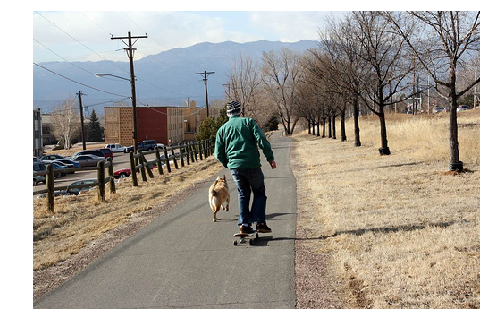

In [56]:
# load and display image
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

In [36]:
print(type(I))
print(I.shape)

<class 'numpy.ndarray'>
(334, 500, 3)


# Attach to existing training model

In [57]:
from sagemaker.pytorch import PyTorchModel, PyTorch

container_serving = "d2-sm-coco-serving"

Consider using directly pyTorch model: https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/pytorch/model.py#L56

In [58]:
model = PyTorchModel(model_data="s3://sagemaker-us-east-2-553020858742/detectron2-ouput/d2-sm-coco-2020-04-18-18-16-08-142/output/model.tar.gz",
                     role=role,
                     entry_point="predict_coco.py", source_dir="container_serving",
                     framework_version="1.4", py_version="3.6",
                     image='{}.dkr.ecr.{}.amazonaws.com/{}:{}'.format(account, region, container_serving, tag))

In [38]:
predictor = model.deploy(instance_type='ml.p3.16xlarge', 
                         initial_instance_count=1,
                         endpoint_name=f"{container_serving}",
                         tags=[{"Key":"image", "Value":f"{container}:{tag}"}]
                         )

---------------------!

In [60]:
# Deploys the model that was generated by fit() to local endpoint in a container
pred_local = model.deploy(initial_instance_count=1, 
                          instance_type='local',
                          endpoint_name=f"{container_serving}-local"
                         )

algo-1-lnr8o_1  | 2020-04-19 14:56:15,116 [INFO ] pool-1-thread-67 ACCESS_LOG - /172.18.0.1:41406 "GET /ping HTTP/1.1" 200 1
!

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sagemaker/local/image.py", line 614, in run
    self.process = subprocess.Popen(
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sagemaker/local/image.py", line 673, in _stream_output
    sys.stdout.write(stdout)
RuntimeError: Process exited with code: 1

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sagemaker/local/image.py", line 619, in run
    except RuntimeError as e:
RuntimeError: Failed to run: ['docker-compose', '-f', '/tmp/tmp0izpfa7c/docker-compose.yaml', 'up', '--build', '--abort-on-container-exit'], Process exited with code: 1



In [48]:
# send image for inference
image = np.array([I], dtype=np.float32)
response = predictor.predict(image)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (500) from model with message "'CocoPredictor' object has no attribute 'to'". See https://us-east-2.console.aws.amazon.com/cloudwatch/home?region=us-east-2#logEventViewer:group=/aws/sagemaker/Endpoints/d2-sm-coco-serving-2020-04-19-12-55-52-693 in account 553020858742 for more information.

In [ ]:
#visualize inference

from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

    